In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [2]:
file = "C:/Users/USER/Downloads/include_january_all_param.xlsx"
data = pd.read_excel(file,header=3,parse_dates =["time"], index_col ="time")

In [3]:
columns_to_rename = [
    "weather_code (wmo code)",
    "temperature_2m_max (°C)",
    "temperature_2m_min (°C)",
    "temperature_2m_mean (°C)",
    "apparent_temperature_max (°C)",
    "apparent_temperature_min (°C)",
    "apparent_temperature_mean (°C)",
    "sunrise (iso8601)",
    "sunset (iso8601)",
    "daylight_duration (s)",
    "sunshine_duration (s)",
    "rain_sum (mm)",
    "precipitation_hours (h)",
    "wind_speed_10m_max (km/h)",
    "wind_gusts_10m_max (km/h)",
    "wind_direction_10m_dominant (°)",
    "shortwave_radiation_sum (MJ/m²)",
    "et0_fao_evapotranspiration (mm)"
]

if len(columns_to_rename) != len(data.columns):
    print("There were some columns deleted, reason unrelated/redundance/development column")

data = data[columns_to_rename]
# Continue with renaming the columns


data.rename(columns={
    "weather_code (wmo code)": 'weather_code',
    "temperature_2m_max (°C)": 'temperature_2m_max',
    "temperature_2m_min (°C)": 'temperature_2m_min',
    "temperature_2m_mean (°C)": 'temperature_2m_mean',
    "apparent_temperature_max (°C)": 'apparent_temperature_max',
    "apparent_temperature_min (°C)": 'apparent_temperature_min ',
    "apparent_temperature_mean (°C)":'apparent_temperature_mean',
    "sunrise (iso8601)"	: 'sunrise',
    "sunset (iso8601)"	: 'sunset',
    "daylight_duration (s)" : 'daylight_duration',
    "sunshine_duration (s)"	: 'sunshine_duration',
    "rain_sum (mm)" : 'rain_sum',
    "precipitation_hours (h)"  : 'precipitation_hours',
    "wind_speed_10m_max (km/h)" : 'wind_speed_10m_max',
    "wind_gusts_10m_max (km/h)" : 'wind_gusts_10m_max',
    "wind_direction_10m_dominant (°)" : 'wind_direction_10m_dominant',
    "shortwave_radiation_sum (MJ/m²)" : 'shortwave_radiation_sum',
    "et0_fao_evapotranspiration (mm)" : 'et0_fao_evapotranspiration'},inplace=True)


There were some columns deleted, reason unrelated/redundance/development column


In [4]:
print(data)

            weather_code  temperature_2m_max  temperature_2m_min  \
time                                                               
2022-01-01            63                26.8                22.0   
2022-01-02            65                26.3                21.7   
2022-01-03            53                27.4                22.3   
2022-01-04            65                27.7                22.1   
2022-01-05            51                29.3                21.2   
...                  ...                 ...                 ...   
2022-12-27            53                27.2                22.2   
2022-12-28            51                28.3                21.4   
2022-12-29            53                27.5                22.2   
2022-12-30            51                28.1                19.2   
2022-12-31            51                28.4                20.8   

            temperature_2m_mean  apparent_temperature_max  \
time                                                  

In [5]:
label_encoder = LabelEncoder()
data['weather_code_encoded'] = label_encoder.fit_transform(data['weather_code'])
data['wind_direction_10m_dominant_encoded'] = label_encoder.fit_transform(data['wind_direction_10m_dominant'])

# Example of preprocessing datetime variables (sunrise, sunset, iso8601)
data['sunrise'] = pd.to_datetime(data['sunrise'])
data['sunset'] = pd.to_datetime(data['sunset'])
data['hour_of_sunrise'] = data['sunrise'].dt.hour
data['hour_of_sunset'] = data['sunset'].dt.hour


# Drop the original categorical and datetime variables
data.drop(['weather_code', 'wind_direction_10m_dominant', 'sunrise', 'sunset'], axis=1, inplace=True)

In [6]:
# Select variables for standardization and normalization
variables_to_standardize = ['temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max',
                            'apparent_temperature_min ', 'wind_speed_10m_max', 'wind_gusts_10m_max',
                            'shortwave_radiation_sum']

variables_to_normalize = [ 'rain_sum', "precipitation_hours",
                           'sunshine_duration', 'daylight_duration', 'et0_fao_evapotranspiration']

# Standardization
scaler_standardization = StandardScaler()
data[variables_to_standardize] = scaler_standardization.fit_transform(data[variables_to_standardize])

# Normalization
scaler_normalization = MinMaxScaler()
data[variables_to_normalize] = scaler_normalization.fit_transform(data[variables_to_normalize])

# Display the first few rows of the transformed data
print(data.head())

            temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
time                                                                      
2022-01-01           -1.806814           -0.302132                 23.4   
2022-01-02           -2.077606           -0.657105                 23.5   
2022-01-03           -1.481863            0.052841                 24.2   
2022-01-04           -1.319388           -0.183808                 24.3   
2022-01-05           -0.452853           -1.248727                 24.6   

            apparent_temperature_max  apparent_temperature_min   \
time                                                              
2022-01-01                 -1.764825                  -0.181376   
2022-01-02                 -1.951268                  -0.401073   
2022-01-03                 -1.764825                   0.184787   
2022-01-04                 -1.503804                  -0.034911   
2022-01-05                 -0.235991                  -1.353095   

    

In [7]:
# the Y value or target 
target_variable = ['temperature_2m_mean']
# the X value or feature 
features = ['temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min ', 'apparent_temperature_mean',
       'daylight_duration', 'sunshine_duration',
       'rain_sum', 'precipitation_hours', 'wind_speed_10m_max',
       'wind_gusts_10m_max', 'shortwave_radiation_sum',
       'et0_fao_evapotranspiration', 'weather_code_encoded',
       'wind_direction_10m_dominant_encoded', 'hour_of_sunrise',
       'hour_of_sunset']


sequence_length = 30  # Use 30 days of historical data for prediction


# empty string for storing sequence lenght
sequences = []
target = []

#the code for sequence length. It is good to grouping it as 30 to detect monthly weather pattern
sequence_data_values = data[features].values
target_values = data[target_variable].values

for i in range(len(data) - sequence_length): # the total rows data is subrtracted with sequence length
    sequence_data = sequence_data_values[i:i+sequence_length] # In loop and grouping 30 rows together
    sequences.append(sequence_data)#adding the data into empty string of sequence
    target.append(target_values[i+sequence_length])
#converting to numpy for faster processing
X = np.array(sequences)
y = np.array(target)

In [8]:
import os
os.chdir("c:/Users/USER/AppData/Local/Programs/Microsoft VS Code")

In [9]:
from keras.models import load_model

# Load the model
model = load_model('psychic.h5')
predict = model.predict(X)

11/11 [==============================] - 1s 6ms/step


In [11]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
mae = mean_absolute_error(y, predict)
r2 = r2_score(y, predict)
mse = mean_squared_error(y, predict)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")
print(f"Mean Squared Error (MSE): {mse}")

Mean Absolute Error (MAE): 0.4674312694037138
R-squared (R2): 0.623034407030318
Mean Squared Error (MSE): 0.3405723319580533


In [12]:

# Calculate the absolute errors
errors = abs(predict - y)

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y)

# Calculate accuracy
accuracy = 100 - np.mean(mape)

# Print the accuracy as a percentage
print('Accuracy: {:.2f}%'.format(accuracy))

Accuracy: 98.16%


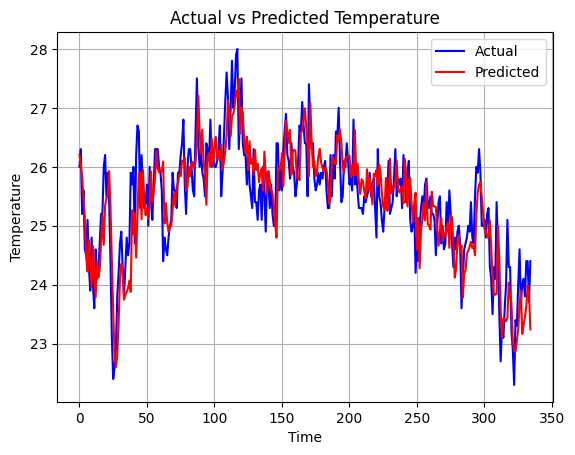

In [13]:
import matplotlib.pyplot as plt
# plot comparasion between actual and predicted for validation of 20% y test

# Plot the actual values
plt.plot(y, label='Actual', color='blue')

# Plot the predicted values
plt.plot(predict, label='Predicted', color='red')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [14]:
import plotly.graph_objs as go
 
# The dataset datetime is in dataframe, the array does not include it. Set the array with relative to dataframe datetimes
array = predict 
array1 = y
dates = pd.date_range(start='1/1/2022',end ='11/1/2022', periods=len(array))  
dates1 = pd.date_range(start='1/1/2022',end ='11/1/2022', periods=len(array1))  


df = pd.DataFrame(array, index=dates, columns=['Value'])
df_resampled = df.resample('D').mean()


df1 = pd.DataFrame(array1, index=dates1, columns=['Value'])
df_resampled1 = df1.resample('D').mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_resampled.index, y=df_resampled['Value'], mode="lines", name='pred'))

# Plot actual temperature
fig.add_trace(go.Scatter(x=df_resampled1.index, y=df_resampled1['Value'], mode='lines', name='Actual Temperature'))

# Update layout
fig.update_layout(title='Actual vs Predicted Temperature Daily',
                  xaxis_title='Date',
                  yaxis_title='Temperature (°C)')
fig.show()